Which Areas of New York City Are the Safest?

A Data-Driven Exploration Using the NYPD Crime API

Step 1: Setup

Install required libraries and import them:

In [ ]:
!pip install sodapy pandas matplotlib seaborn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata
from datetime import datetime, timedelta
import geopandas as gpd
from shapely.geometry import Point

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

Step 2: Connect to the NYPD Complaint API

The dataset ID for NYPD complaint data is qgea-i56i.

In [ ]:
DOMAIN = "data.cityofnewyork.us"
DATASET = "qgea-i56i"
client = Socrata(DOMAIN, None)  # no token → limited to 1000/min; fine for demo

In [ ]:
results = client.get(
    DATASET,
    limit=1000000,
    select="cmplnt_fr_dt,ofns_desc,boro_nm,pd_desc,law_cat_cd,addr_pct_cd,lat_lon"
)
df = pd.DataFrame.from_records(results)
df


,cmplnt_fr_dt,ofns_desc,boro_nm,pd_desc,law_cat_cd,addr_pct_cd,lat_lon
0,2008-02-20T00:00:00.000,BURGLARY,BROOKLYN,"BURGLARY,RESIDENCE,DAY",FELONY,88,"{'latitude': '40.692464', 'longitude': '-73.97..."
1,2008-08-21T00:00:00.000,GRAND LARCENY,MANHATTAN,"LARCENY,GRAND FROM BUILDING (NON-RESIDENCE) UN...",FELONY,19,"{'latitude': '40.771341', 'longitude': '-73.95..."
2,2008-04-03T00:00:00.000,FELONY ASSAULT,BROOKLYN,"ASSAULT 2,1,UNCLASSIFIED",FELONY,77,"{'latitude': '40.671245', 'longitude': '-73.92..."
3,2008-08-19T00:00:00.000,PETIT LARCENY,MANHATTAN,"LARCENY,PETIT OF LICENSE PLATE",MISDEMEANOR,32,"{'latitude': '40.813412', 'longitude': '-73.94..."
4,2008-03-10T00:00:00.000,ROBBERY,BROOKLYN,"ROBBERY,OPEN AREA UNCLASSIFIED",FELONY,67,"{'latitude': '40.650142', 'longitude': '-73.94..."
...,...,...,...,...,...,...,...
999995,2010-11-09T00:00:00.000,CRIMINAL MISCHIEF & RELATED OF,MANHATTAN,"MISCHIEF, CRIMINAL 4, BY FIRE",MISDEMEANOR,19,"{'latitude': '40.77881447', 'longitude': '-73...."
999996,2010-12-21T00:00:00.000,PETIT LARCENY,MANHATTAN,"LARCENY,PETIT FROM BUILDING,UN",MISDEMEANOR,18,"{'latitude': '40.757981', 'longitude': '-73.98..."
999997,2010-06-20T00:00:00.000,CRIMINAL MISCHIEF & RELATED OF,MANHATTAN,"CRIMINAL MISCHIEF,UNCLASSIFIED 4",MISDEMEANOR,28,"{'latitude': '40.809747', 'longitude': '-73.95..."
999998,2010-11-04T00:00:00.000,GRAND LARCENY,MANHATTAN,"LARCENY,GRAND FROM PERSON,UNCL",FELONY,17,"{'latitude': '40.75830818', 'longitude': '-73...."


Step 3 – Clean & Engineer Features

In [ ]:
df['lat_lon'].head(20)
# just getting the exact location of the reports so we can pass that into a geospatial api later on

,lat_lon
0,"{'latitude': '40.692464', 'longitude': '-73.97..."
1,"{'latitude': '40.771341', 'longitude': '-73.95..."
2,"{'latitude': '40.671245', 'longitude': '-73.92..."
3,"{'latitude': '40.813412', 'longitude': '-73.94..."
4,"{'latitude': '40.650142', 'longitude': '-73.94..."
5,"{'latitude': '40.855233', 'longitude': '-73.92..."
6,"{'latitude': '40.669126', 'longitude': '-73.97..."
7,"{'latitude': '40.79156983', 'longitude': '-73...."
8,"{'latitude': '40.605188', 'longitude': '-73.95..."
9,"{'latitude': '40.689954', 'longitude': '-73.91..."


In [ ]:
# Convert date + category columns
df['cmplnt_fr_dt'] = pd.to_datetime(df['cmplnt_fr_dt'], errors='coerce')
for col in ['boro_nm','law_cat_cd','ofns_desc']:
    df[col] = df[col].astype('category')

# Safely extract latitude/longitude from dict-like entries
def extract_lat(x):
    if isinstance(x, dict):
        return float(x.get('latitude')) if x.get('latitude') else None
    elif isinstance(x, str) and 'latitude' in x:
        try:
            return float(x.split("'latitude': '")[1].split("'")[0])
        except:
            return None
    return None

def extract_lon(x):
    if isinstance(x, dict):
        return float(x.get('longitude')) if x.get('longitude') else None
    elif isinstance(x, str) and 'longitude' in x:
        try:
            return float(x.split("'longitude': '")[1].split("'")[0])
        except:
            return None
    return None

df['latitude']  = df['lat_lon'].apply(extract_lat)
df['longitude'] = df['lat_lon'].apply(extract_lon)

print(df[['latitude','longitude']].head())
df.info()


    latitude  longitude
0  40.692464 -73.972708
1  40.771341 -73.953418
2  40.671245 -73.926713
3  40.813412 -73.943226
4  40.650142 -73.944674
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   cmplnt_fr_dt  999880 non-null   datetime64[ns]
 1   ofns_desc     1000000 non-null  category      
 2   boro_nm       1000000 non-null  category      
 3   pd_desc       1000000 non-null  object        
 4   law_cat_cd    1000000 non-null  category      
 5   addr_pct_cd   999898 non-null   object        
 6   lat_lon       999999 non-null   object        
 7   latitude      999999 non-null   float64       
 8   longitude     999999 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(2), object(3)
memory usage: 48.6+ MB


Step 4: Crimes by Location

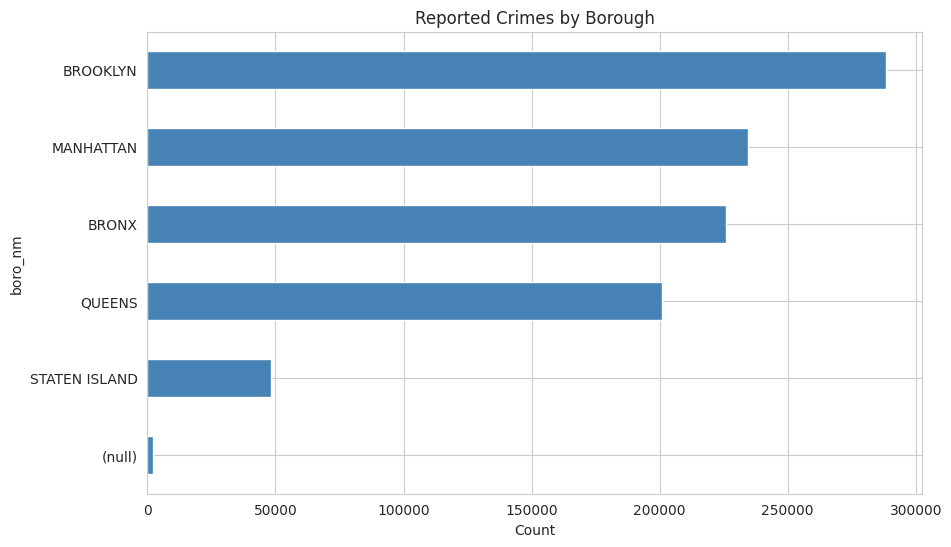

In [ ]:
boro_counts = df['boro_nm'].value_counts().sort_values()
boro_counts.plot(kind='barh', color='steelblue')
plt.title("Reported Crimes by Borough")
plt.xlabel("Count")
plt.show()


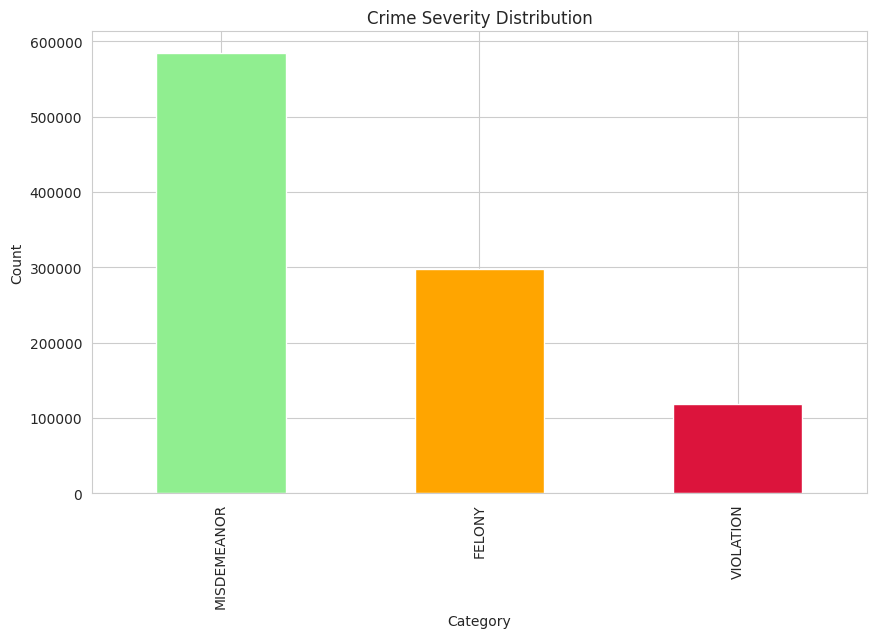

In [ ]:
severity = df['law_cat_cd'].value_counts()
severity.plot(kind='bar', color=['lightgreen','orange','crimson'])
plt.title("Crime Severity Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

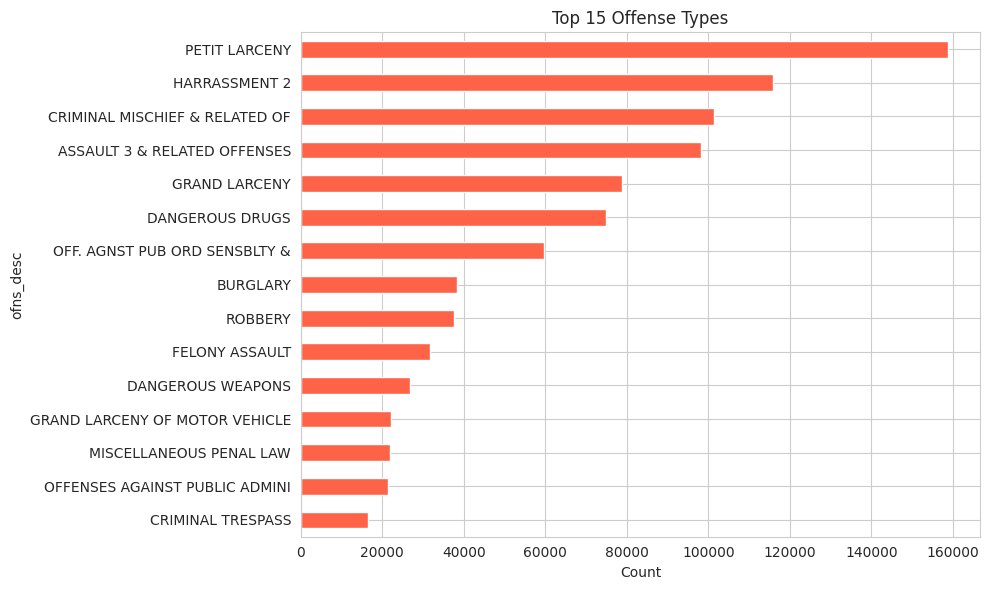

In [ ]:
top_offenses = df['ofns_desc'].value_counts().head(15)
top_offenses.sort_values().plot(kind='barh', color='tomato')
plt.title("Top 15 Offense Types")
plt.xlabel("Count")
plt.tight_layout()
plt.show()


Step 5: Hotspots with contexily + geopandas

In [ ]:
# Define approximate bounding box for NYC
LAT_MIN, LAT_MAX = 40.45, 41.0
LON_MIN, LON_MAX = -74.3, -73.6

# Apply relaxed geographic filter
df = df[
    df['latitude'].between(LAT_MIN, LAT_MAX, inclusive="both") &
    df['longitude'].between(LON_MIN, LON_MAX, inclusive="both")
]

print(f"Rows remaining after filtering: {len(df)}")


Rows remaining after filtering: 999997


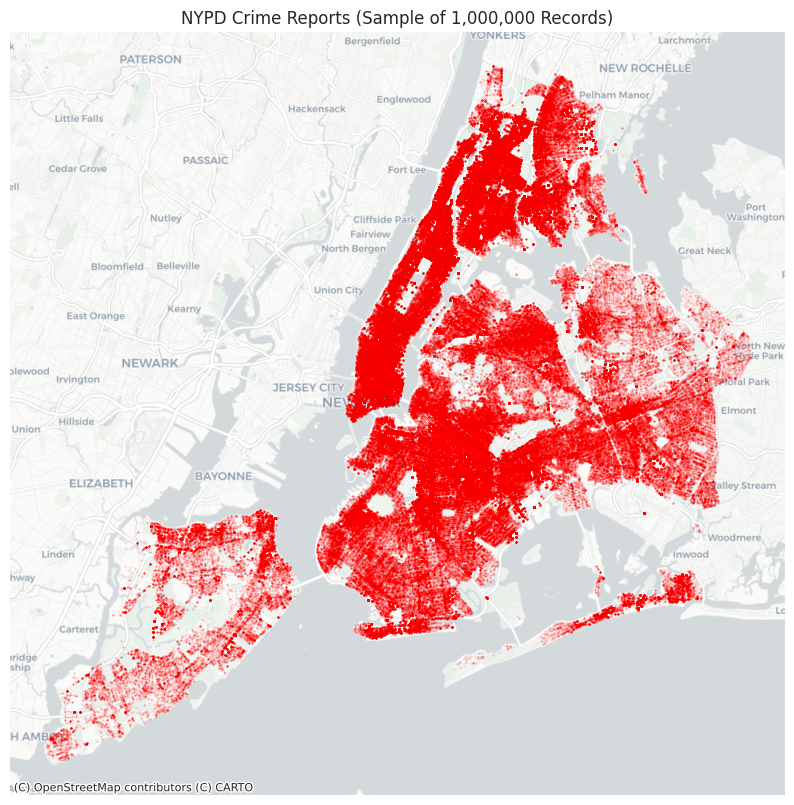

In [ ]:
# Build GeoDataFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326").dropna(subset=['geometry'])

# Reproject to Web Mercator for map tiles
gdf = gdf.to_crs(epsg=3857)

# Plot with updated basemap provider
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, markersize=0.2, alpha=0.1, color="red")

# Use a supported provider name
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title("NYPD Crime Reports (Sample of 1,000,000 Records)")
ax.set_axis_off()
plt.show()


Step 6: Compute a safety index

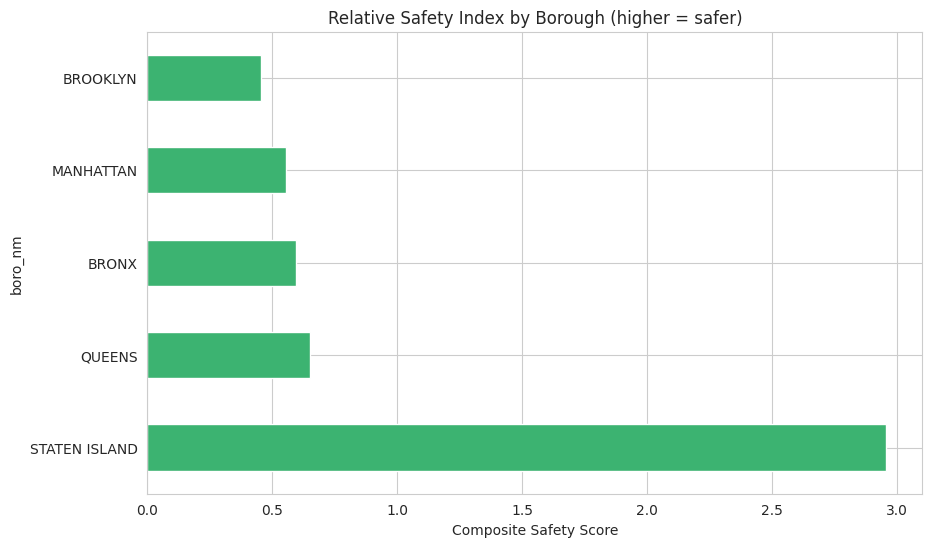

In [ ]:
# Remove rows with missing or literal '(null)' borough names
df = df[df['boro_nm'].notna()]                            # drop NaN
df = df[df['boro_nm'].str.lower().isin(
    ['manhattan', 'brooklyn', 'bronx', 'queens', 'staten island']
)]

# Recalculate safety index
weights = {'FELONY': 3, 'MISDEMEANOR': 2, 'VIOLATION': 1}
df['severity_score'] = df['law_cat_cd'].map(weights).astype(float)

safety = (
    df.groupby('boro_nm')['severity_score']
      .agg(['mean', 'count'])
      .dropna()
)

safety['safety_index'] = (1 / safety['mean']) * (1 / (safety['count'] / safety['count'].max()))
safety = safety.sort_values('safety_index', ascending=False)

# Plot again
safety['safety_index'].plot(kind='barh', color='mediumseagreen')
plt.title("Relative Safety Index by Borough (higher = safer)")
plt.xlabel("Composite Safety Score")
plt.show()
